If you run the code on google colab uncomment you need to run the line below. If you launch the notebook from myBinder.org this will not be necessary.

In [ ]:
# !pip install pygfunction matplotlib numpy scipy SecondaryCoolantProps  CoolProp

## Design of borehole heat exchanger

You are given the task of designing a borehole field for a system that is expected to have a mean power exchanged with the ground over the year Q_average = - 6kW, a maximum monthly load of   Q_month = -16 kW and a 6 hour pulse of intensity  Q_6hours = -25 kW

Select a borehole configuration (e.g. borehole positions and length) suitable to satisfy the condition of minimum fluid temperature not less than 0 C. 
The cost is increasing with the drilling length, therefore configurations with lower overall length are favorable.

In [290]:
Q_average = -6000
Q_month = -16000 
Q_6hours = -25000


We will use the following data for thermophysical properties of the ground, geometrical configuration and flow condition.

In [291]:
# Base configuration data

# Ground properties 
rho_ground = 2600    #kg/m^3         #density
cp_ground  = 800     # J /(kg K)     #specific heat capacity
k_ground   = 2.8     #W/(m K)        #conductivity    
T_0   =  9          # °C             #undisturbed ground temperature 

# Borehole configuration (water&Ethanol 20% mixture)
r_b = 0.06    #m             #borehole radius
k_grout = 1.2 #W/(mK).       #Grout conductivity
k_pipe = 0.33 #W/(mK).       #Pipe conductivity
s = 0.065     #m             #distance between pipe center (assuming symmetric configuration)   
r_i = 0.042/2  #m             #internal pipe diameter (assuming symmetric configuration)   
r_o = 0.048/2   #m             #outer pipe diameter (assuming symmetric configuration)   

# H =   150     #m             # This time I remove the borehole length as it will be a design parameter

from CoolProp.CoolProp import PropsSI

Tref = 0 + 273.15
secondaryfluid = 'INCOMP::MEA-20%'

T_freeze = PropsSI('T_freeze',secondaryfluid)
cp_fluid  = PropsSI('C','T',Tref,'P',101325,secondaryfluid)  #specific heat 
rho_fluid = PropsSI('D','T',Tref,'P',101325,secondaryfluid)
mu_fluid  = PropsSI('viscosity','T',Tref,'P',101325,secondaryfluid)
k_fluid  = PropsSI('conductivity','T',Tref,'P',101325,secondaryfluid)

# Design mass flow rate
mb  = 0.5	# kg/s

In [292]:
alpha_ground = k_ground/(rho_ground*cp_ground) # m^2/s  thermal diffusivity
print(f'alpha_ground = {alpha_ground}')

alpha_ground = 1.3461538461538462e-06


Import functions contained in file borehole_resistance.py and define the function compute_resistances according to the procedure explained in borehole_resistances.ipynb. 

In [293]:
from borehole_resistances import evaluate_nusselt, cross_section_Rb, cross_section_Ra

import math

def compute_resistances(mb, H):
    w = mb / (rho_fluid * math.pi * r_i**2)
    Re = rho_fluid * w * 2 * r_i / mu_fluid 
    Pr = mu_fluid * cp_fluid / (2 * r_i)
	
    Nu = evaluate_nusselt(Re, Pr)
    hi = Nu * k_fluid / (2 * r_i)

    Rconv = 1 / (2 * math.pi * r_i * hi) 
    Rcond = 1 / (2 * math.pi * k_pipe) * math.log(r_o / r_i)
    Rp = (Rcond + Rconv) / 2   

    θ1 = s / (2 * r_b)
    θ2 = r_b / r_o
    θ3 = r_o / s

    σ  = (k_grout - k_ground) / (k_grout + k_ground)
    β  = 2 * math.pi * k_grout * Rp 

    Rb = cross_section_Rb(θ1, θ2, θ3, σ, β, k_grout)
    Ra = cross_section_Ra(θ1, θ2, θ3, σ, β, k_grout)

    η = H / (mb * cp_fluid * math.sqrt(Ra * Rb))
    Rbstar =  Rb * η * (1 / math.tanh(η))
    return Rbstar

## Design procedure

The goal of the design is to find a suitable configuration that allows to minimize the drilling cost while satisfying given constraints of minimum accepted temperature and installation footprint area. A common condition is to consider a minimum fluid temperature greater than 0 °C . For this exercise I will assume that my condition is that the value of average temperature $\bar{T}_f(t)=(T_{f_{in}} (t)  + T_{f_{out}} (t))/2$  is greater than zero.

We are given the thermal load characterized by 3 pulses. 
- The net power exchanged with the ground during a year  Q_average
- The maximum monthly load Q_month
- The maximum peak load Q_6hours


We can compute the expected minimum borehole temperature after 20 years for a given borehole field configuration as the superposition of three terms relative to the response to these load’s components. 

$$T_b(t) -T_0= q_{\textrm{20years}} \, R_{\textrm{20years}}+ q_{\textrm{1month}} \, R_{\textrm{1month}} + q_{\textrm{6hours}} \, R_{\textrm{6hours}} $$




The expression above allows to compute the temperature of the borehole wall T_b (t) (also known as outer problem). This temperature difference is the sum of three load-resistance products. The loads in this formula are in W/m and represent the average power exchanged per meter of borehole during each interval of interest. These values can be obtained from the overall loads exchanged with the whole borehole field (Q_average, Q_month and Q_6hours) simply by scaling by the overall borehole length.

$$q_{\textrm{20years}}=Q_{\textrm{average}}/(N_b \, H) \qquad	  q_{\textrm{1month}}=Q_{\textrm{1month}}/(N_b \, H) \qquad	q_{\textrm{6hours}}=Q_{\textrm{6hours}}/(N_b \, H)$$


Where N_b is the number of boreholes and H is the borehole length.
In order to compute the value of the mean fluid temperature (T_f ) ̅(t), we then need to include the contribution of the effective borehole resistance (also known as internal problem). We then obtain the following formula.


$$\bar{T}_f(t) -T_0= q_{\textrm{20years}} \, R_{\textrm{20years}}+ q_{\textrm{1month}} \, R_{\textrm{1month}} + q_{\textrm{6hours}} \, R_{\textrm{6hours}} + q_{\textrm{6hours}} \,R_b^{\star} $$


The resistances $R_{\textrm{20years}}$, $R_{\textrm{1month}}$, $R_{\textrm{6hours}}$  can be calculated as follow.

$\large t_f=t_{20y}  +t_{1m}  +t_{6h}  \qquad t_{f_2}= t_{20y}  +t_{1m} \qquad t_{f_1}=t_{20y}$


$\large R_{\textrm{20years}}=\frac{(g(t_f )-g(t_f  -t_{f_1} ))}{2 \pi k_g} = \frac{((g(t_{20y}  +t_{1m}  +t_{6h} )-g(t_{1m}  +t_{6h} ) ))}{2\pi k_g}$

$\large R_{\textrm{1month}} = \frac{((g(t_f  -t_{f_1} )-g(t_f  -t_{f_2} ) ))}{2 \pi k_g} = \frac{g(t_{1m}  +t_{6h} )-g(t_{6h} ) }{2 \pi k_g}$

$\large R_{\textrm{6hours}} =\frac{g(t_f  -t_{f_2} )}{2 \pi k_g} = \frac{g(t_{6h} )}{2 \pi k_g}$

The evaluation of g(t) is performed using the software pygfunction. The code below is a modification of the sample code found at the github page of the software https://github.com/MassimoCimmino/pygfunction 


The design is an iterative process. To get an initial guess for a starting configuration I will consider a long term pulse with a power per meter of 15 W/m.  Given that the average long term power is 6000 W, the initial configuration will have a total length of 400 meters.
In this case I will consider two boreholes of 200 meters at a distance B of 7 meters between each other.

In [295]:
# Evaluation of the relevant time for the evaluation of g-functions necessary for the ASHRAE method
ty = 3600 * 8760 * 20
tm = 3600 * 24 * 30
t6h = 3600 * 6
tf = ty + tm + t6h
tf2 = ty + tm
tf1 = ty

In [298]:
import pygfunction as gt
import numpy as np

B = 7
H_1 = 200


time = np.array([tf-tf2, tf - tf1, tf]) 
# time = np.array([t6h, tm+t6h, ty+tm+t6h]) 
boreField_1 = gt.boreholes.rectangle_field(N_1=1, N_2=2, B_1=B, B_2=B, H=H_1, D=6., r_b=r_b)
gFunc_1 = gt.gfunction.gFunction(boreField_1, alpha=1.34615e-6, time=time)

print(f'gfuncton at [tf-tf2, tf - tf1, tf]{gFunc_1.gFunc}')    # this line returns the values of the gfunction for t=time

gfuncton at [tf-tf2, tf - tf1, tf][1.463701   3.83956905 8.01103043]


In [301]:
gg_1 = gFunc_1.gFunc   # vector containing the values of the gfunction for the three pulses of interest.

R20years_1 = 1/(2*math.pi*k_ground)* (gg_1[2] - gg_1[1])
R1month_1  = 1/(2*math.pi*k_ground)* (gg_1[1] - gg_1[0])
R6hours_1  = 1/(2*math.pi*k_ground)* gg_1[0]
Rbstar_1   = compute_resistances(mb,H_1)

print(f'R20years = {R20years_1} (m K)/W')
print(f'Rmonth = {R1month_1} (m K)/W')
print(f'R6hours = {R6hours_1} (m K)/W')
print(f'Rbstar = {Rbstar_1} (m K)/W')


R20years = 0.2371102495645354 (m K)/W
Rmonth = 0.13504683681479138 (m K)/W
R6hours = 0.08319830357678223 (m K)/W
Rbstar = 0.07454645142511668 (m K)/W


In [302]:
Nb_1 = len(boreField_1)

q20years_1 = Q_average/(Nb_1*H_1)
q1month_1  = Q_month/(Nb_1*H_1)
q6hours_1  = Q_6hours/(Nb_1*H_1)

print(f'q20years = {q20years_1} W/m')
print(f'q1month = {q1month_1} W/m')
print(f'q6hours = {q6hours_1} W/m')



q20years = -15.0 W/m
q1month = -40.0 W/m
q6hours = -62.5 W/m


In [303]:
DeltaT20years_1 = q20years_1 * R20years_1
DeltaT1month_1  = q1month_1 * R1month_1
DeltaT6hours_1  = q6hours_1 * R6hours_1
DeltaRbstar_1   = q6hours_1 * Rbstar_1

Tfmean = DeltaT20years_1 + DeltaT1month_1 + DeltaT6hours_1 + DeltaRbstar_1 + T_0

print(f'DeltaT20years_1 = {DeltaT20years_1} °C')
print(f'DeltaT1month_1 = {DeltaT1month_1} °C')
print(f'DeltaT6hours_1 = {DeltaT6hours_1} °C')
print(f'DeltaRbstar_1 = {DeltaRbstar_1} °C')
print(f'Tfmean = {Tfmean} °C')

DeltaT20years_1 = -3.556653743468031 °C
DeltaT1month_1 = -5.401873472591655 °C
DeltaT6hours_1 = -5.19989397354889 °C
DeltaRbstar_1 = -4.38707016835243 °C
Tfmean = -9.545491357961005 °C


The mean fluid temperature Tfmean obtained is less than 0°C. **We cannot accept this configuration!**

In [304]:
B = 8
H_2 = 245

time = np.array([tf-tf2, tf - tf1, tf]) 
# time = np.array([t6h, tm+t6h, ty+tm+t6h]) 
boreField_2 = gt.boreholes.rectangle_field(N_1=2, N_2=2, B_1=B, B_2=B, H=H_2, D=6., r_b=r_b)
gFunc_2 = gt.gfunction.gFunction(boreField_2, alpha=alpha_ground, time=time)

print(f'gfuncton at [tf]{gFunc_2.gFunc}')    # this line returns the values of the gfunction for t=time

gfuncton at [tf][ 1.46383213  3.84013139 10.70975812]


In [228]:
gg_2 = gFunc_2.gFunc   # vector containing the values of the gfunction for the three pulses of interest.

R20years_2 = 1/(2*math.pi*k_ground)* (gg_2[2] - gg_2[1])
R1month_2  = 1/(2*math.pi*k_ground)* (gg_2[1] - gg_2[0])
R6hours_2  = 1/(2*math.pi*k_ground)* gg_2[0]
Rbstar_2   = compute_resistances(mb,H_2)

print(f'R20years = {R20years_2} (m K)/W')
print(f'Rmonth = {R1month_2} (m K)/W')
print(f'R6hours = {R6hours_2} (m K)/W')
print(f'Rbstar = {Rbstar_2} (m K)/W')


R20years = 0.3904768040623392 (m K)/W
Rmonth = 0.1350713475536436 (m K)/W
R6hours = 0.08320575712999254 (m K)/W
Rbstar = 0.07938908518893456 (m K)/W


In [236]:
Nb_2 = len(boreField_2)

q20years_2 = Q_average/(Nb_2*H_2)
q1month_2  = Q_month/(Nb_2*H_2)
q6hours_2  = Q_6hours/(Nb_2*H_2)

print(f'Nb = {Nb_2} ')
print(f'q20years = {q20years_2} W/m')
print(f'q1month = {q1month_2} W/m')
print(f'q6hours = {q6hours_2} W/m')

Nb = 4 
q20years = -6.122448979591836 W/m
q1month = -16.3265306122449 W/m
q6hours = -25.510204081632654 W/m


In [261]:
DeltaT20years_2 = q20years_2 * R20years_2
DeltaT1month_2  = q1month_2 * R1month_2
DeltaT6hours_2  = q6hours_2 * R6hours_2
DeltaRbstar_2   = q6hours_2 * Rbstar_2

Tfmean = DeltaT20years_2 + DeltaT1month_2 + DeltaT6hours_2 + DeltaRbstar_2 + T_0

print(f'DeltaT20years_2 = {DeltaT20years_2} °C')
print(f'DeltaT1month_2 = {DeltaT1month_2} °C')
print(f'DeltaT6hours_2 = {DeltaT6hours_2} °C')
print(f'DeltaRbstar_2 = {DeltaRbstar_2} °C')
print(f'Tfmean = {Tfmean} °C')

DeltaT20years_2 = -2.39067431058575 °C
DeltaT1month_2 = -2.2052464906717324 °C
DeltaT6hours_2 = -2.122595845152871 °C
DeltaRbstar_2 = -2.025231765023841 °C
Tfmean = 0.25625158856580477 °C


## Comparison of configurations response function

In the code below we plot the g-functions for the two configurations over the full transient of the configuration. The plot shows the non-dimensional response temperature as a function of non-dimensional time $log(t/t_s)$ where $t_s= H^2 / 9 \alpha_{g} $ is the time where the response approach steady state. 

In [296]:
from math import floor, log

log_t_over_ts_fulltimerange = np.arange(floor(log(6 * 3600 / ts)), 3.25, 0.25)  # calculate the g-function during the whole transient.

ts_1 = H_1**2 / (9 * alpha_ground)  # time when g-function approach steady state
fulltimerange_1 = ts_1 * np.exp(log_t_over_ts_fulltimerange)
gFunc_overfulltimerange_1 = gt.gfunction.gFunction(boreField_1, alpha=alpha_ground, time=fulltimerange_1)
log_t_over_ts_ASHRAEmethod_1 = np.log(np.array(time) / ts_1)

ts_2 = H_2**2 / (9 * alpha_ground)  # time when g-function approach steady state
fulltimerange_2 = ts_2 * np.exp(log_t_over_ts_fulltimerange)
gFunc_overfulltimerange_2 = gt.gfunction.gFunction(boreField_2, alpha=alpha_ground, time=fulltimerange_2)
log_t_over_ts_ASHRAEmethod_2 = np.log(np.array(time) / ts_2)

# print(f'gfunc over full time range {gFunc_overfulltimerange_1.gFunc}')
# print(f'full time range (years) {fulltimerange/(8760*3600)}')
# print(f'log_t_over_ts_ASHRAEmethod {log_t_over_ts_ASHRAEmethod_1}')

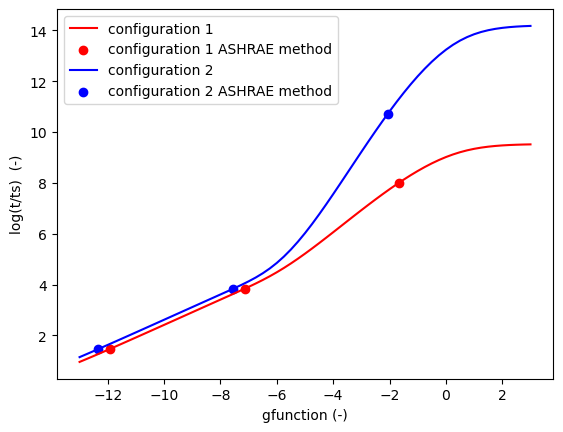

In [281]:
import numpy as np
import matplotlib.pyplot as plt


fig, (ax1) = plt.subplots(1, 1)

ax1.plot(log_t_over_ts_fulltimerange, gFunc_overfulltimerange_1.gFunc, color = 'red', label = 'configuration 1')
ax1.scatter(log_t_over_ts_ASHRAEmethod_1, gFunc_1.gFunc, color = 'red',  label = 'configuration 1 ASHRAE method')
ax1.plot(log_t_over_ts_fulltimerange, gFunc_overfulltimerange_2.gFunc, color = 'blue', label = 'configuration 2')
ax1.scatter(log_t_over_ts_ASHRAEmethod_2, gFunc_2.gFunc, color = 'blue',  label = 'configuration 2 ASHRAE method')

ax1.set_xlabel('gfunction (-)')
ax1.set_ylabel('log(t/ts)  (-)')

plt.legend()

# Show plot
plt.show()
